In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from models.siren import SIREN
from utils.metrics import TVLoss

In [2]:
def load_images(view0_path, view1_path, view2_path): # future TODO: change to dataloader
    img0 = cv2.imread(view0_path, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.imread(view1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(view2_path, cv2.IMREAD_GRAYSCALE)

    img0 = (img0 - 127.5) / 127.5
    img1 = (img1 - 127.5) / 127.5
    img2 = (img2 - 127.5) / 127.5

    return torch.from_numpy(img0).float(), torch.from_numpy(img1).float(), torch.from_numpy(img2).float()

def patch_based_loss(pred, target, patch_size=3):
    h, w = pred.shape[-2:]
    pad = patch_size // 2

    pred_padded = F.pad(pred, (pad, pad, pad, pad), mode='reflect')
    target_padded = F.pad(target, (pad, pad, pad, pad), mode='reflect')

    pred_patches = F.unfold(pred_padded, kernel_size=patch_size, stride=1)
    target_patches = F.unfold(target_padded, kernel_size=patch_size, stride=1)

    patch_losses = torch.abs(pred_patches - target_patches).mean(dim=1)

    return patch_losses.view(h, w)

def pixel_wise_loss(pred, target):
    return torch.abs(pred - target)

def compute_loss(pred, target, use_patch_loss, patch_size):
    if use_patch_loss:
        return patch_based_loss(pred, target, patch_size).mean()
    else:
        return pixel_wise_loss(pred, target).mean()


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

# Load images
img0, img1, img2 = load_images("/home/rintoyagawa/ssd2/Code/invdepth/data/images/wood_mbs_dataB20_v0.png"
, "/home/rintoyagawa/ssd2/Code/invdepth/data/images/wood_mbs_dataB20_v1.png",
                                "/home/rintoyagawa/ssd2/Code/invdepth/data/images/wood_mbs_dataB20_v2.png")

scene_depth = 1.65  # meters, adjust based on your scene
# Blender settings

focal_length_m = 0.055  # adjust based on your Blender camera setting
sensor_width_m = 0.024  # adjust based on your Blender camera setting

f_dist = focal_length_m
h, w = img0.shape

import torch
import torch.nn.functional as F
import numpy as np
from scipy.spatial.transform import Rotation

def get_camera_matrices(width, height, focal_length_m, sensor_width_m,
                       location=[0,0,0], rotation=[0,0,0]):
    """
    カメラの内部・外部パラメータ行列を計算

    Args:
        width, height: 画像サイズ
        focal_length_m: 焦点距離（メートル）
        sensor_width_m: センサー幅（メートル）
        location: カメラ位置 [x,y,z]
        rotation: カメラ回転 [rx,ry,rz]（度）
    """
    # 内部パラメータ
    focal_px = (width * focal_length_m) / sensor_width_m
    K = np.array([
        [focal_px, 0, width/2],
        [0, focal_px, height/2],
        [0, 0, 1]
    ])

    # 外部パラメータ
    rotation_rad = np.array(rotation) * np.pi / 180
    R = Rotation.from_euler('xyz', rotation_rad).as_matrix()
    t = np.array(location).reshape(3, 1)

    RT = np.hstack([R, t])

    return K, RT
def warp_with_projection(image, depth, K_ref, K_tar, RT_ref_to_tar, device='cuda'):
    """
    投影ベースの画像ワーピング
    """
    B, C, H, W = image.shape

    # ピクセル座標グリッドの生成
    y = torch.arange(H).to(device)
    x = torch.arange(W).to(device)
    y, x = torch.meshgrid(y, x, indexing='ij')
    pixels = torch.stack([x, y, torch.ones_like(x)], dim=0).float()  # (3,H,W)
    pixels = pixels.unsqueeze(0).repeat(B,1,1,1)  # (B,3,H,W)

    # カメラ行列をテンソルに変換
    K_ref = torch.tensor(K_ref, dtype=torch.float32).to(device)
    K_tar = torch.tensor(K_tar, dtype=torch.float32).to(device)
    RT_ref_to_tar = torch.tensor(RT_ref_to_tar, dtype=torch.float32).to(device)

    # 3D点への逆投影
    inv_K_ref = torch.inverse(K_ref)
    rays = torch.matmul(inv_K_ref, pixels.reshape(B,3,-1))  # (B,3,H*W)
    points_3d = rays * depth.reshape(B,1,-1)  # (B,3,H*W)

    # 同次座標に変換
    points_4d = torch.cat([points_3d,
                          torch.ones((B,1,H*W), device=device)],
                          dim=1)  # (B,4,H*W)

    # ターゲット視点への変換
    points_tar = torch.matmul(RT_ref_to_tar, points_4d)  # (B,3,H*W)

    # ターゲット視点での投影
    points_2d = torch.matmul(K_tar, points_tar)  # (B,3,H*W)
    points_2d = points_2d[:,:2] / (points_2d[:,2:] + 1e-7)  # (B,2,H*W)

    # 正規化座標系に変換 (-1,1)
    points_2d = points_2d.reshape(B,2,H,W)
    normalized_points = torch.stack([
        2 * points_2d[:,0] / (W-1) - 1,
        2 * points_2d[:,1] / (H-1) - 1
    ], dim=-1)

    # 画像のワーピング
    warped = F.grid_sample(image, normalized_points,
                          mode='bilinear',
                          padding_mode='zeros',
                          align_corners=True)

    # 有効マスクの生成
    valid_mask = (normalized_points.abs() <= 1).all(dim=-1, keepdim=True)
    valid_mask = valid_mask & (points_tar[:,2:3] > 0).reshape(B,1,H,W)

    return warped, valid_mask

def compute_relative_transform(RT1, RT2):
    """2つの変換行列間の相対変換を計算"""
    RT1_4x4 = np.eye(4)
    RT1_4x4[:3] = RT1
    RT2_4x4 = np.eye(4)
    RT2_4x4[:3] = RT2

    relative = RT2_4x4 @ np.linalg.inv(RT1_4x4)
    return relative[:3]

def warp_with_inverse_depth_mesh(image, inverse_depth, focal_length_m, sensor_width_m, device, K, RT_ref_to_view):
    """
    スケーリングを改善したワーピング関数
    """
    # 入力テンソルの形状を統一
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    if len(inverse_depth.shape) == 2:
        inverse_depth = inverse_depth.unsqueeze(0)

    h, w = image.shape[-2:]

    safety_factor = 1e-3
    depth = torch.reciprocal(inverse_depth + safety_factor)# 1 / inverse_depth + safety_factor

    # 相対変換の計算

    warped_image, mask = warp_with_projection(
            image, depth, K, K, RT_ref_to_view, device)

    return warped_image, mask



def train_inverse_depth(img0, img1, img2, f_dist, sensor, device, locations, rotations, num_epochs=200, patch_size=3, use_patch_loss = True): # TODO: change img arguments to dataset
    h, w = img0.shape
    x_loc, y_loc = torch.meshgrid(torch.linspace(-1, 1, steps=w), torch.linspace(-1, 1, steps=h), indexing="xy")
    coords = torch.cat((x_loc.reshape(-1, 1), y_loc.reshape(-1, 1)), dim=1)
    learning_rate = 1e-4
    net_inverse_depth = SIREN(in_dim=2, hidden_dim=256, hidden_layers=2, out_dim=1, outermost_linear=True)
    optimizer = torch.optim.AdamW(net_inverse_depth.parameters(), lr=learning_rate)
    net_inverse_depth = net_inverse_depth.to(device)
    coords = coords.to(device)
    img0, img1, img2 = img0.to(device), img1.to(device), img2.to(device)
    x_loc, y_loc = x_loc.to(device), y_loc.to(device)

    tv_reg = TVLoss()
    psnr1, psnr2= [], []

    for _ in tqdm(range(num_epochs)):
        K, RT_ref = get_camera_matrices(w, h, focal_length_m, sensor_width_m,
                                  locations[0], rotations[0])

        _, RT1 = get_camera_matrices(w, h, focal_length_m, sensor_width_m,
                               locations[1], rotations[1])
        _, RT2 = get_camera_matrices(w, h, focal_length_m, sensor_width_m,
                               locations[2], rotations[2])
        RT_ref_to_1 = compute_relative_transform(RT_ref, RT1)
        RT_ref_to_2 = compute_relative_transform(RT_ref, RT2)
        # define the relative transformation between the reference view and the target view
        
        RT_ref_to_1 = [[1.0000, 0.0000, 0.0000, -0.02],
                [0.0000, 1.0000, 0.0000, 0.00],
                [0.0000, 0.0000, 1.0000, 0.0000]]  
        RT_ref_to_2 = [[1.0000, 0.0000, 0.0000, -0.04],
                [0.0000, 1.0000, 0.0000, 0.00],
                [0.0000, 0.0000, 1.0000, 0.0000]]


        pred_inverse_depth = net_inverse_depth(coords)
        pred_inverse_depth = pred_inverse_depth.reshape(1, h, w)
        pred_inverse_depth = (pred_inverse_depth + 1) / 2.0 # 0~1


        pred_img1, mask1 = warp_with_inverse_depth_mesh(
        img0,
        pred_inverse_depth,
        focal_length_m,
        sensor_width_m,
        device,
        K,
        RT_ref_to_1
    )
        pred_img2, mask2 = warp_with_inverse_depth_mesh(
        img0,
        pred_inverse_depth,
        focal_length_m,
        sensor_width_m,
        device,
        K,
        RT_ref_to_2
    )
        # Compute losses
        tv_loss = tv_reg(pred_inverse_depth.reshape(1, 1, h, w))
        reconstruction_loss1 = compute_loss(pred_img1, img1.reshape(1, 1, h, w), use_patch_loss, patch_size)
        reconstruction_loss2 = compute_loss(pred_img2, img2.reshape(1, 1, h, w), use_patch_loss, patch_size)

        # Total loss
        loss = reconstruction_loss1 + reconstruction_loss2 + tv_loss * 15e-3

        pred_img1 = pred_img1.reshape(h, w)
        pred_img2 = pred_img2.reshape(h, w)

        with torch.no_grad():
            err1 = skimage.metrics.peak_signal_noise_ratio(
                img1.detach().cpu().numpy(),
                pred_img1.detach().cpu().numpy())
            err2 = skimage.metrics.peak_signal_noise_ratio(
                img2.detach().cpu().numpy(),
                pred_img2.detach().cpu().numpy())
            psnr1.append(err1)
            psnr2.append(err2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return psnr1, psnr2, pred_inverse_depth, pred_img1, pred_img2, mask1, mask2

device: cuda


In [4]:
# results
ref_params = {
        'location': [-68.6291, -150.675, 119.469],
        'rotation': [84, 0, 226]
    }

target_params_1 = {
        'location': [-68.6491, -150.675, 119.469],
        'rotation': [84, 0, 226]      # 回転は同じ
    }
target_params_2 = {
        'location': [-68.6691, -150.675, 119.469],
        'rotation': [84, 0, 226]      # 回転は同じ
    }
results = train_inverse_depth(img0, img1, img2, f_dist, sensor_width_m, device, locations=[ref_params['location'], target_params_1['location'], target_params_2['location']], rotations=[ref_params['rotation'], target_params_1['rotation'], target_params_2['rotation']], use_patch_loss=False)

  0%|          | 0/200 [00:00<?, ?it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]


  4%|▎         | 7/200 [00:00<00:07, 26.87it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

  9%|▉         | 18/200 [00:00<00:04, 42.53it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 15%|█▌        | 30/200 [00:00<00:03, 51.42it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 21%|██        | 42/200 [00:00<00:02, 53.58it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 27%|██▋       | 54/200 [00:01<00:02, 52.69it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 34%|███▍      | 68/200 [00:01<00:02, 56.80it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 40%|████      | 80/200 [00:01<00:02, 53.48it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 46%|████▌     | 92/200 [00:01<00:02, 51.50it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 49%|████▉     | 98/200 [00:02<00:02, 50.13it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 55%|█████▌    | 110/200 [00:02<00:01, 49.81it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 60%|██████    | 121/200 [00:02<00:01, 48.21it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 66%|██████▌   | 131/200 [00:02<00:01, 44.35it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 70%|███████   | 141/200 [00:02<00:01, 45.61it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 74%|███████▎  | 147/200 [00:03<00:01, 47.39it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 79%|███████▉  | 158/200 [00:03<00:00, 48.64it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 84%|████████▍ | 169/200 [00:03<00:00, 49.43it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 90%|█████████ | 180/200 [00:03<00:00, 49.71it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

 96%|█████████▌| 192/200 [00:03<00:00, 51.31it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

100%|██████████| 200/200 [00:04<00:00, 48.91it/s]

[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -4.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108547e-14]]
[[ 1.00000000e+00 -4.18471059e-17  1.52112038e-17 -2.00000000e-02]
 [ 5.87670934e-17  1.00000000e+00 -2.64432565e-19  2.84217094e-14]
 [-2.86011244e-18  7.46090618e-19  1.00000000e+00  1.42108

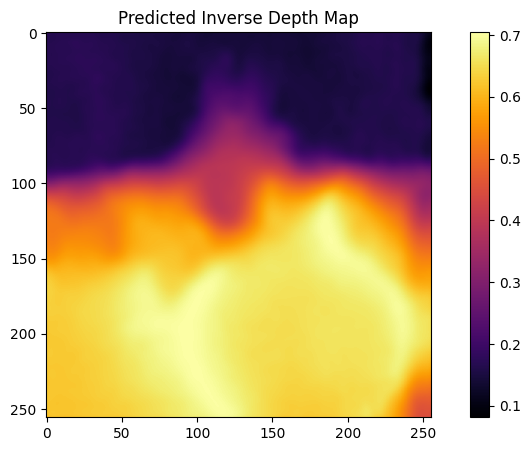

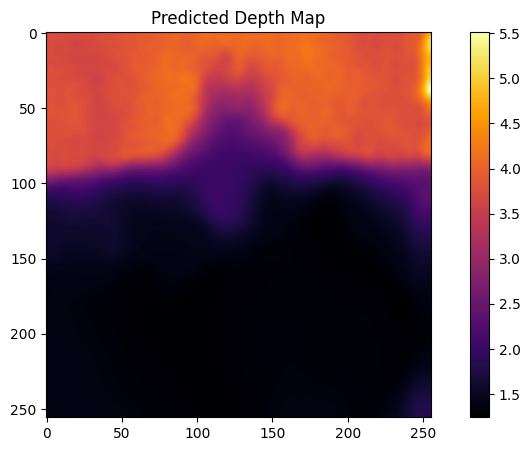

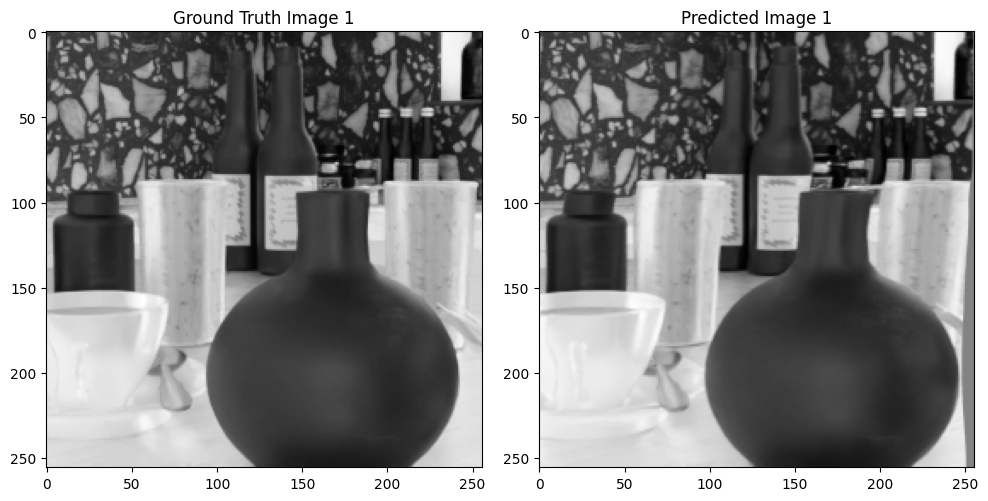

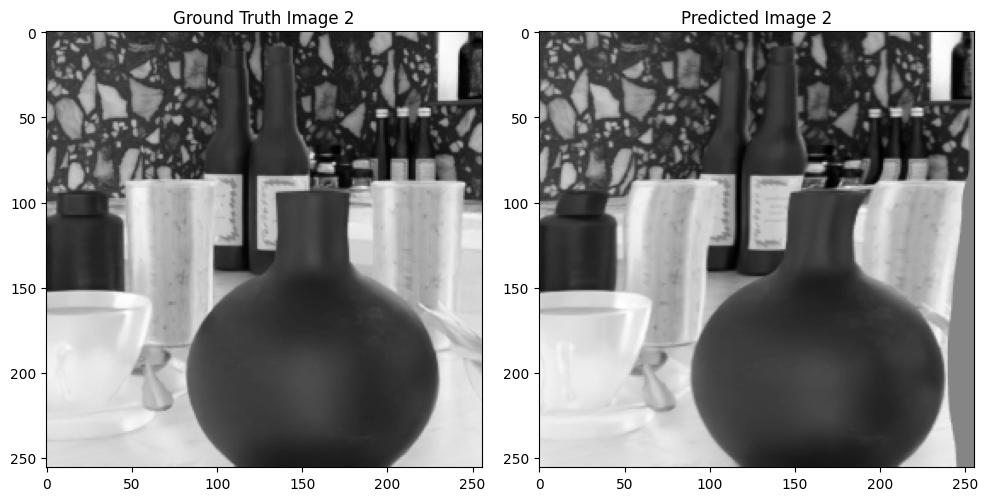

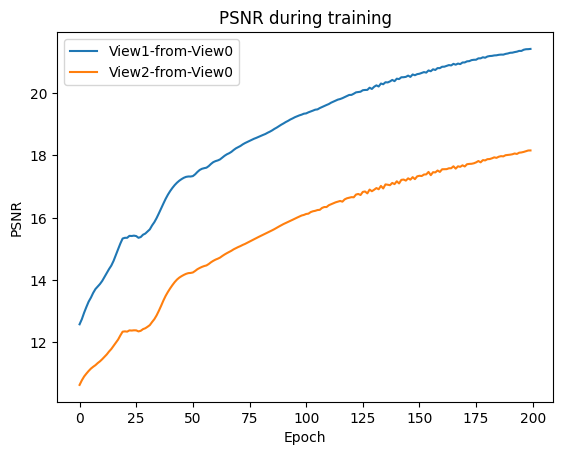

In [5]:

psnr_v1fromv0, psnr_v2fromv0, pred_inverse_depth, pred_img_v1fromv0, pred_img_v2fromv0, pred_mask_1, pred_mask_2 = results
pred_inverse_depth = -pred_inverse_depth
# show the result of predicted inverse depth map
plt.figure(figsize=(10, 5))
plt.imshow(pred_inverse_depth.squeeze().cpu().detach().numpy(), cmap='inferno') # Call detach() before converting to NumPy array.
plt.title('Predicted Inverse Depth Map')
plt.colorbar()
plt.show()

# also the depth map computing the inverse of inverse depth map
pred_depth = 1 / (pred_inverse_depth + 0.1)
plt.figure(figsize=(10, 5))
plt.imshow(pred_depth.squeeze().cpu().detach().numpy(), cmap='inferno') # Call detach() before converting to NumPy array.
plt.title('Predicted Depth Map')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img1.cpu().detach().numpy(), cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Ground Truth Image 1')

plt.subplot(122)
plt.imshow(pred_img_v1fromv0.cpu().detach().numpy(), cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Predicted Image 1')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img2.cpu().detach().numpy(), cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Ground Truth Image 2')

plt.subplot(122)
plt.imshow(pred_img_v2fromv0.cpu().detach().numpy(), cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Predicted Image 2')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(psnr_v1fromv0, label='View1-from-View0')
plt.plot(psnr_v2fromv0, label='View2-from-View0')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR during training')
plt.legend()
plt.show()